In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We upload our dataset from Google drive and then we unzip the file.

In [3]:
root_dir = "/content/drive/MyDrive/Intel-Image-Classification.zip"
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/Intel-Image-Classification.zip -d /content

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/Intel-Image-Classification/train/mountain/7539.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7551.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7560.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7565.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7578.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7581.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7586.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7647.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7652.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7654.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/7662.jpg  
  inflating: /content/Intel-Image-Classification/train/mountain/767.jpg  
  inflating: /content/Intel-Image-Classification/tr

In [5]:
import os
train_dir = "/content/Intel-Image-Classification/train"
test_dir = "/content/Intel-Image-Classification/test"

In [6]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

The *torchvision.transforms* module provides various functionality to preprocess the images, here first we resize the image for (100*100) shape, we rotate the images by angle, then transforms them into tensors and finally we apply normalization.

In [7]:
#Compose transformations

transforms = T.Compose([
        T.Resize((64,64)),
        T.RandomRotation(degrees=(0,20)),
        T.ToTensor(),
        T.Normalize(0.5, 0.5)
    ])

We used ImageFolder to load images which is useful in our case. In particularly, our dataset consist of 6 types of images and they are stored in corresponding folders from which the classes are taken.

In [8]:
train_set = ImageFolder(train_dir, transform=transforms)
test_set = ImageFolder(test_dir, transform=transforms)

In [9]:
data, label = train_set[0]
print(data.shape)

torch.Size([3, 64, 64])


Now we compute an exploration of our data. In particularly, in the following codes we will see the length of our train and test sets, the classes and also the number of images per classes in each set.

In [10]:
# Dataset len
num_train = len(train_set)
num_test = len(test_set)
print(f"Num. training samples: {num_train}")
print(f"Num. test samples:     {num_test}")

Num. training samples: 14034
Num. test samples:     3000


In [11]:
print("Following classes are there : \n", train_set.classes)

Following classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [12]:
import pandas as pd
nums = {}
for outcome in train_set.classes:
    nums[outcome] = len(os.listdir(train_dir + '/' + outcome))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["Number of images in the train set"])
img_per_class

,Number of images in the train set
buildings,2191
forest,2271
glacier,2404
mountain,2512
sea,2274
street,2382


In [13]:
numt = {}
for outcome in test_set.classes:
    numt[outcome] = len(os.listdir(test_dir + '/' + outcome))

img_per_classt = pd.DataFrame(numt.values(), index=numt.keys(), columns=["Number of images in the test set"])
img_per_classt

,Number of images in the test set
buildings,437
forest,474
glacier,553
mountain,525
sea,510
street,501


In the following code, using the previous results, we can see that the two sets are proportioned.

In [14]:
numm = {}
for outcome in test_set.classes:
    numm[outcome] = len(os.listdir(test_dir + '/' + outcome))/len(os.listdir(train_dir + '/' + outcome))

img_per_classm = pd.DataFrame(numm.values(), index=numm.keys(), columns=["Number of images in the test set"])
img_per_classm

,Number of images in the test set
buildings,0.199452
forest,0.208719
glacier,0.230033
mountain,0.208997
sea,0.224274
street,0.210327


We show an example of image (choosing position 72) in the train set. Since our dataset consists of images in form of Tensors, we use imshow() method of matplotlib python library to visualize images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label : buildings


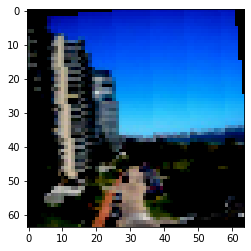

In [15]:
def display_img(img,label):
    print(f"Label : {train_set.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the image in the dataset at position 72
display_img(*train_set[72])

Now, we proceed randomly splitting the images of the train set in order to get the validation set, choosing as percentage the 10%.

In [16]:
#Validation set
val_frac= 0.1
num_val = int(num_train * val_frac)
num_train = num_train - num_val 

We can visualize the new length of the train set and the one of the validation set.

In [17]:
from torch.utils.data import random_split
 
torch.manual_seed(20)
train_data, val_data = random_split(train_set,[num_train, num_val])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 12631
Length of Validation Data : 1403


We split the dataset into batches choosing as size 64, using *DataLoader()*. 
Then, we show an example of a single batch, using make_grid() which gives us an overall view of images in batch in the form of an image grid.

In [18]:
from torch.utils.data.dataloader import DataLoader

#load the train and validation into batches.
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle = True, drop_last=True, num_workers = 2)
val_loader = DataLoader(val_data, batch_size, shuffle=False, drop_last=False, num_workers = 2)
test_loader = DataLoader(test_set, batch_size, shuffle=False, drop_last=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


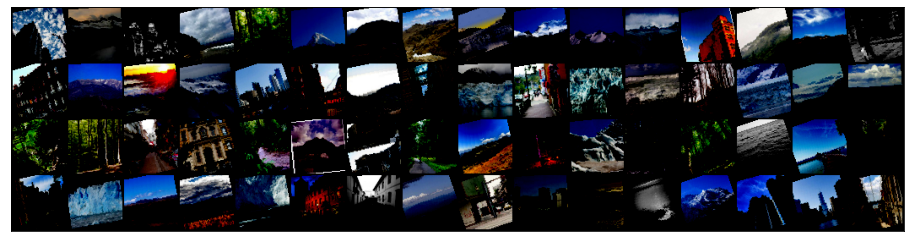

In [19]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [20]:
#inputs, labels = next(iter(train_loader))
#print(inputs.shape)
#print(labels.shape)

We start our model with 5 convolutional layers and then we proceed removing one layer at a time in order to establish which is the one with the best perfomance.

First of all, we create a simple model without FC, and then we see the output dimension of the convolutional layers:

In [21]:
import torch.nn as nn

#SimpleCNN5

class SimpleCNN5(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        #Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),       
        nn.MaxPool2d(kernel_size=2, stride=2),

        #Layer 5
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(1024),       
        nn.MaxPool2d(kernel_size=2, stride=2)

    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

Our 2D CNN model expects as input a tensor of shape: [N, C, H, W], where:

*   N is the number of samples (batch_size);
*   C is the number of channels (1 for grayscale images, 3 for RGB images);
*   H and W are height and width dimension of the images;

We have to add the batch dimension to img_5.

In [22]:
#Create the model
model = SimpleCNN5()
img_5, label_5 = train_data[0]
img_5 = img_5.unsqueeze(dim=0)
#Get the output
output = model(img_5)
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

4096


Now we can add some fully connected layers to our CNN model and the obtained result 4096 is the number of features of input for the first FC.

In [23]:
#CNN5

class CNN5(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        #Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),       
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        #Layer 5
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(1024),       
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(4096, 1024),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        # a second FC layer
        nn.Linear(1024, 512),
        nn.Dropout(p=0.25),
        nn.ReLU(),       
        # the final Classification Layer
        nn.Linear(512,6)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [24]:
# Create the model
model = CNN5()
output = model(img_5)

In [25]:
torch.cuda.is_available()

True

In [26]:
dev = torch.device('cuda')
print(dev)

cuda


We define an optimizer using the Stochastic Gradient Descent and setting a learning rate= 0.01. 
Then we also define the loss criterion using the Cross Entropy Loss.

In [27]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [28]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        results= [0,0,0]
        val_loss = None
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels) in tqdm(loaders[split]):
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
            if val_loss == None or epoch_loss['val'] < val_loss:
                val_loss = epoch_loss['val']
                results = [epoch_accuracy['train'], epoch_accuracy['val'], epoch_accuracy['test']]
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        return results

In [29]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,   
           "test": test_loader}

Now we train the model for 10 epochs.

CNN5(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 1024, kernel_size=(3, 3)

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1: TrL=1.0039, TrA=0.6214, VL=0.7608, VA=0.7133, TeL=0.7718, TeA=0.7162,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2: TrL=0.7093, TrA=0.7380, VL=0.6637, VA=0.7481, TeL=0.6859, TeA=0.7378,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3: TrL=0.6113, TrA=0.7765, VL=0.5646, VA=0.7988, TeL=0.5836, TeA=0.7952,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4: TrL=0.5404, TrA=0.8007, VL=0.5365, VA=0.8146, TeL=0.5538, TeA=0.8006,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5: TrL=0.4807, TrA=0.8273, VL=0.5278, VA=0.8138, TeL=0.5146, TeA=0.8144,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6: TrL=0.4314, TrA=0.8450, VL=0.4709, VA=0.8259, TeL=0.4884, TeA=0.8197,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7: TrL=0.3912, TrA=0.8574, VL=0.4737, VA=0.8237, TeL=0.4863, TeA=0.8226,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8: TrL=0.3532, TrA=0.8717, VL=0.4992, VA=0.8272, TeL=0.4938, TeA=0.8218,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9: TrL=0.3167, TrA=0.8890, VL=0.5617, VA=0.8075, TeL=0.6068, TeA=0.7950,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10: TrL=0.2815, TrA=0.9002, VL=0.6071, VA=0.7979, TeL=0.5999, TeA=0.7993,


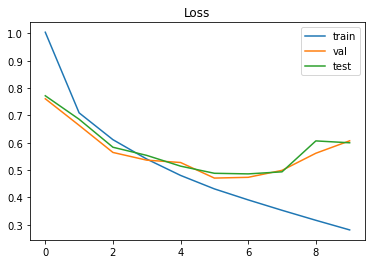

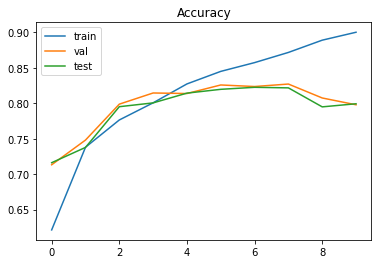

In [30]:
# Train model
result5 = train(model, loaders, optimizer, criterion, epochs=10, dev= dev)

We repeat the procedure removing one layer at a time in our model.

In [31]:
#SimpleCNN4

class SimpleCNN4(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        #Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),       
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [32]:
#Create the model
model = SimpleCNN4()
img_4, label_4 = train_data[0]
img_4 = img_4.unsqueeze(dim=0)
#Get the output
output = model(img_4)
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

18432


In [33]:
#CNN4

class CNN4(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        #Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),       
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(18432, 4096),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        # a second FC layer
        nn.Linear(4096, 1024),
        nn.Dropout(p=0.25),
        nn.ReLU(),       
        # the final Classification Layer
        nn.Linear(1024,6)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [34]:
# Create the model
model4 = CNN4()
output = model4(img_4)
output.shape

torch.Size([1, 6])

In [35]:
# Define an optimizier
optimizer = optim.SGD(model4.parameters(), lr = 0.01)
# Define a loss 
#criterion = nn.CrossEntropyLoss()

CNN4(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU()
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1: TrL=0.9367, TrA=0.6442, VL=0.7588, VA=0.7177, TeL=0.7844, TeA=0.7008,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2: TrL=0.6862, TrA=0.7437, VL=0.6032, VA=0.7776, TeL=0.6109, TeA=0.7762,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3: TrL=0.5852, TrA=0.7855, VL=0.5895, VA=0.7877, TeL=0.5871, TeA=0.7839,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4: TrL=0.5111, TrA=0.8143, VL=0.5339, VA=0.8080, TeL=0.5372, TeA=0.8081,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5: TrL=0.4514, TrA=0.8353, VL=0.5469, VA=0.8059, TeL=0.5384, TeA=0.8077,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6: TrL=0.4004, TrA=0.8560, VL=0.4996, VA=0.8274, TeL=0.4798, TeA=0.8325,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7: TrL=0.3577, TrA=0.8718, VL=0.5092, VA=0.8127, TeL=0.5290, TeA=0.8094,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8: TrL=0.3225, TrA=0.8825, VL=0.4736, VA=0.8374, TeL=0.4645, TeA=0.8381,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9: TrL=0.2787, TrA=0.9016, VL=0.4649, VA=0.8381, TeL=0.4697, TeA=0.8350,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10: TrL=0.2464, TrA=0.9142, VL=0.4717, VA=0.8368, TeL=0.4753, TeA=0.8335,


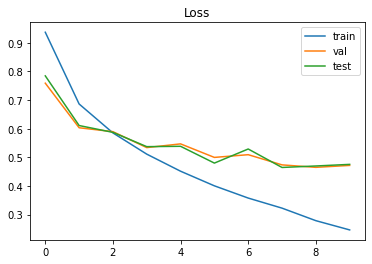

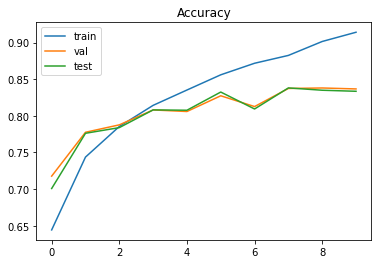

In [36]:
# Train model_4layers
result4= train(model4, loaders, optimizer, criterion, epochs=10, dev= dev)

In [37]:
#SimpleCNN3

class SimpleCNN3(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [38]:
#Create the model
model = SimpleCNN3()
img_3, label_3 = train_data[0]
img_3 = img_3.unsqueeze(dim=0)
#Get the output
output = model(img_3)
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

50176


In [39]:
#CNN3

class CNN3(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        # Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(50176, 4096),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        # a second FC layer
        nn.Linear(4096, 1024),
        nn.Dropout(p=0.25),
        nn.ReLU(),       
        # the final Classification Layer
        nn.Linear(1024,6)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [40]:
# Create the model
model = CNN3()
output = model(img_3)

In [41]:
# Define an optimizier

optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
#criterion = nn.CrossEntropyLoss()

CNN3(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=50176, out_features=4096, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=1

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1: TrL=0.9445, TrA=0.6444, VL=0.8222, VA=0.6726, TeL=0.8321, TeA=0.6828,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2: TrL=0.7042, TrA=0.7404, VL=0.8116, VA=0.6999, TeL=0.8466, TeA=0.6882,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3: TrL=0.5951, TrA=0.7830, VL=0.6269, VA=0.7619, TeL=0.6285, TeA=0.7692,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4: TrL=0.5261, TrA=0.8065, VL=0.5916, VA=0.7831, TeL=0.5976, TeA=0.7759,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5: TrL=0.4661, TrA=0.8299, VL=0.5597, VA=0.7952, TeL=0.5622, TeA=0.8007,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6: TrL=0.4074, TrA=0.8555, VL=0.5475, VA=0.8001, TeL=0.5556, TeA=0.7988,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7: TrL=0.3616, TrA=0.8692, VL=0.5256, VA=0.8131, TeL=0.5586, TeA=0.8118,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8: TrL=0.3044, TrA=0.8893, VL=0.5524, VA=0.8175, TeL=0.5461, TeA=0.8095,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9: TrL=0.2706, TrA=0.9055, VL=0.5356, VA=0.8204, TeL=0.5373, TeA=0.8180,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10: TrL=0.2192, TrA=0.9241, VL=0.5715, VA=0.8203, TeL=0.5499, TeA=0.8245,


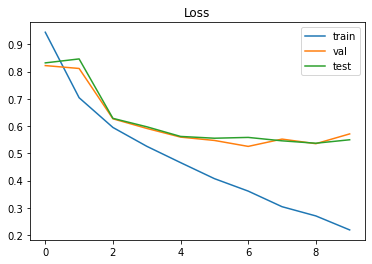

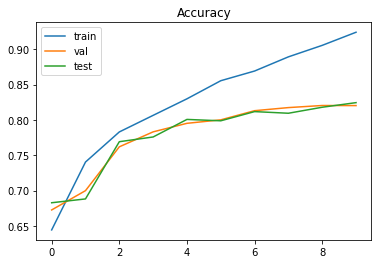

In [42]:
# Train model_3layers
result3= train(model, loaders, optimizer, criterion, epochs=10, dev= dev)

In [43]:
#SimpleCNN2

class SimpleCNN2(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [44]:
#Create the model
model = SimpleCNN2()
img_2, label_2 = train_data[0]
img_2 = img_2.unsqueeze(dim=0)
#Get the output
output = model(img_2)
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

115200


In [45]:
#CNN2

class CNN2(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(115200, 4096),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        # a second FC layer
        nn.Linear(4096, 1024),
        nn.Dropout(p=0.25),
        nn.ReLU(),       
        # the final Classification Layer
        nn.Linear(1024,6)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [46]:
# Create the model
model = CNN2()
output = model(img_2)

In [47]:
# Define an optimizier

optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
#criterion = nn.CrossEntropyLoss()

CNN2(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=115200, out_features=4096, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=6, bias=True)
  )
)


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1: TrL=0.9975, TrA=0.6172, VL=0.8098, VA=0.6935, TeL=0.8426, TeA=0.6772,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2: TrL=0.7812, TrA=0.7051, VL=0.7480, VA=0.7093, TeL=0.7750, TeA=0.7148,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3: TrL=0.6823, TrA=0.7416, VL=0.7229, VA=0.7278, TeL=0.7295, TeA=0.7254,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4: TrL=0.6084, TrA=0.7722, VL=0.6846, VA=0.7325, TeL=0.6897, TeA=0.7396,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5: TrL=0.5550, TrA=0.7923, VL=0.7262, VA=0.7299, TeL=0.7257, TeA=0.7295,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6: TrL=0.4980, TrA=0.8161, VL=0.6317, VA=0.7769, TeL=0.6416, TeA=0.7755,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7: TrL=0.4346, TrA=0.8441, VL=0.6095, VA=0.7774, TeL=0.6260, TeA=0.7686,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8: TrL=0.3898, TrA=0.8553, VL=0.6450, VA=0.7697, TeL=0.6440, TeA=0.7675,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9: TrL=0.3472, TrA=0.8767, VL=0.5903, VA=0.7954, TeL=0.6086, TeA=0.7907,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10: TrL=0.3034, TrA=0.8901, VL=0.6584, VA=0.7874, TeL=0.6504, TeA=0.7769,


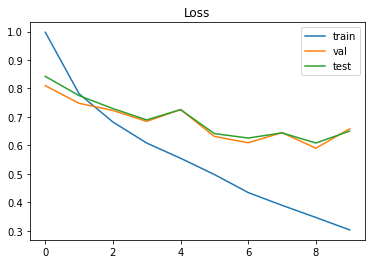

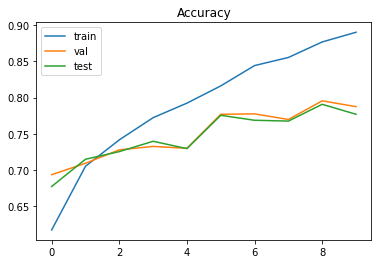

In [48]:
# Train model_2layers
result2 = train(model, loaders, optimizer, criterion, epochs=10, dev= dev)

In [49]:
#SimpleCNN1

class SimpleCNN1(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [50]:
#Create the model
model = SimpleCNN1()
img_1, label_1 = train_data[0]
img_1 = img_1.unsqueeze(dim=0)
#Get the output
output = model(img_1)

out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

61504


In [51]:
#CNN1

class CNN1(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(61504, 4096),
        nn.Dropout(p=0.25),
        nn.ReLU(),
        # a second FC layer
        nn.Linear(4096, 1024),
        nn.Dropout(p=0.25),
        nn.ReLU(),       
        # the final Classification Layer
        nn.Linear(1024,6)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) 
    output = self.fc_layers(x) 
    return output

In [52]:
# Create the model
model = CNN1()
output = model(img_1)

In [53]:
# Define an optimizier

optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
#criterion = nn.CrossEntropyLoss()

CNN1(
  (conv_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=61504, out_features=4096, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=6, bias=True)
  )
)


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1: TrL=1.0671, TrA=0.5916, VL=0.9013, VA=0.6542, TeL=0.9273, TeA=0.6508,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2: TrL=0.8555, TrA=0.6751, VL=0.8208, VA=0.6954, TeL=0.8361, TeA=0.6742,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3: TrL=0.7514, TrA=0.7177, VL=0.7559, VA=0.7184, TeL=0.7561, TeA=0.7196,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4: TrL=0.6906, TrA=0.7405, VL=0.7050, VA=0.7420, TeL=0.7131, TeA=0.7327,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5: TrL=0.6391, TrA=0.7654, VL=0.7332, VA=0.7286, TeL=0.7513, TeA=0.7286,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6: TrL=0.5867, TrA=0.7832, VL=0.6512, VA=0.7661, TeL=0.6761, TeA=0.7594,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7: TrL=0.5440, TrA=0.8046, VL=0.6897, VA=0.7449, TeL=0.7278, TeA=0.7422,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8: TrL=0.5097, TrA=0.8148, VL=0.6547, VA=0.7613, TeL=0.6653, TeA=0.7582,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9: TrL=0.4765, TrA=0.8259, VL=0.6463, VA=0.7655, TeL=0.6761, TeA=0.7585,


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10: TrL=0.4487, TrA=0.8353, VL=0.6928, VA=0.7584, TeL=0.7170, TeA=0.7501,


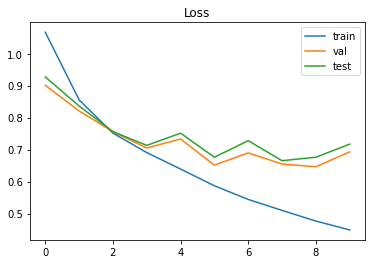

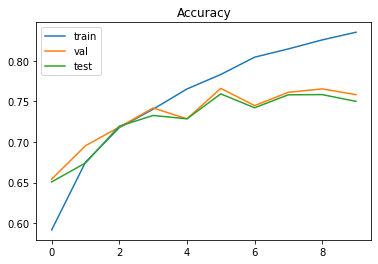

In [54]:
# Train model_1layers
result1 = train(model, loaders, optimizer, criterion, epochs=10, dev= dev)

In [55]:
percent5 = [str(round(num *100,2)) + '%' for num in result5]
percent4 = [str(round(num *100,2)) + '%' for num in result4]
percent3 = [str(round(num *100,2)) + '%' for num in result3]
percent2 = [str(round(num *100,2)) + '%' for num in result2]
percent1 = [str(round(num *100,2)) + '%' for num in result1]

Here we show a summary table to easily read the result of each model and estabilish which is the best one. 
In our case we obtain that the Convolutional Neural Network with four layers (CNN4) has the best performance.

In [56]:
import pandas as pd

results=[percent5,percent4,percent3,percent2, percent1]
models= ['5 Layers', '4 Layers', '3 Layers', '2 Layers', '1 Layer']

df=pd.DataFrame(results, columns=['Train', 'Validation', 'Test'], index= models, dtype= str)
df


,Train,Validation,Test
5 Layers,84.5%,82.59%,81.97%
4 Layers,90.16%,83.81%,83.5%
3 Layers,86.92%,81.31%,81.18%
2 Layers,87.67%,79.54%,79.07%
1 Layer,82.59%,76.55%,75.85%


We also show the confusion matrix which compares the actual target values with those predicted by the model.

In [57]:
#CONFUSION MATRIX
#function that perform inference
def predict(net, loader,dev):
  net.to(dev)
  predictions_list = []
  with torch.no_grad():
    for (input, labels) in loader:
      # Move to CUDA
      input = input.to(dev)
      pred = net(input)
      _,pred_labels = pred.max(1)
      pred_labels.tolist()
      for lab in pred_labels:
        lab = lab.item()
        predictions_list.append(str(lab))
  return predictions_list
            

In [58]:
#inference on test set
predicted_labels = predict(model4, test_loader, dev=dev)

In [59]:
#extracting ground truth labels
true_labels = []
for _ ,label in test_loader:
  for lab in label:
    lab = lab.item()
    true_labels.append(str(lab))

In [60]:
labels = [str(x) for x in range(0,6)]
print (labels)

['0', '1', '2', '3', '4', '5']


In [61]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels, labels=labels)
cm

array([[346,  13,   8,   6,  15,  49],
       [  1, 460,   2,   2,   3,   6],
       [  2,   2, 462,  44,  39,   4],
       [  7,   4, 101, 378,  33,   2],
       [ 16,   2,  30,  22, 434,   6],
       [ 37,  17,   3,   4,   7, 433]])

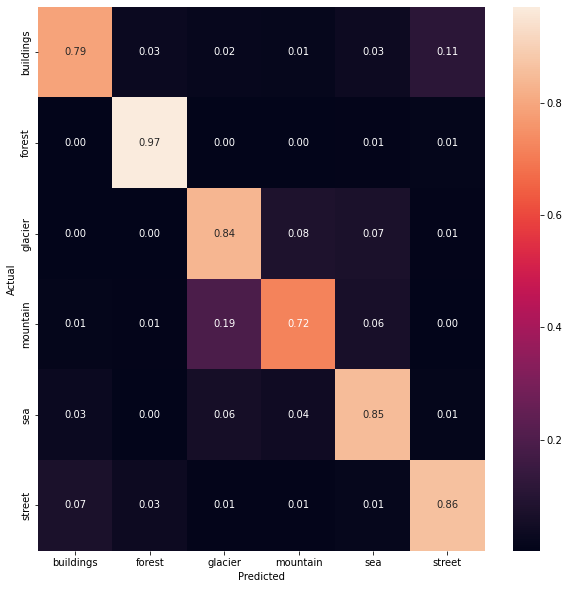

In [62]:
import seaborn as sns
import numpy as np

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=train_set.classes, yticklabels=train_set.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)